In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind


In [2]:
expr = pd.read_csv(
    "GSE19187_expression.txt.txt",
    sep="\t",
    comment="!",
    index_col=0
)

expr.shape


(33297, 38)

In [3]:
expr.iloc[:5, :5]


,GSM475618,GSM475619,GSM475620,GSM475621,GSM475622
ID_REF,,,,,
7892501,4.848740,4.316679,4.514895,2.526050,3.119298
7892502,4.144095,3.794749,4.616208,4.274711,4.613874
7892503,2.497601,4.128514,4.224153,2.666992,2.547122
7892504,9.623439,8.923612,9.106287,10.017760,9.408893
7892505,2.463959,2.931401,2.540900,2.682718,2.832507


In [4]:
control_samples = [
    "GSM475621","GSM475622","GSM475623","GSM475624",
    "GSM475631","GSM475633","GSM475638","GSM475642",
    "GSM475645","GSM475648","GSM475649"
]

ar_samples = [
    "GSM475619","GSM475626","GSM475627","GSM475632",
    "GSM475634","GSM475635","GSM475636","GSM475637",
    "GSM475643","GSM475646","GSM475650","GSM475651",
    "GSM475652","GSM475653"
]

asthma_samples = [
    "GSM475618","GSM475620","GSM475625","GSM475628",
    "GSM475629","GSM475630","GSM475639","GSM475640",
    "GSM475641","GSM475644","GSM475647","GSM475654",
    "GSM475655"
]


In [5]:
# counts
len(control_samples), len(ar_samples), len(asthma_samples)


(11, 14, 13)

In [6]:
# overlap check
set(control_samples) & set(ar_samples), \
set(control_samples) & set(asthma_samples), \
set(ar_samples) & set(asthma_samples)


(set(), set(), set())

In [7]:
# all samples accounted for
len(set(control_samples + ar_samples + asthma_samples))


38

In [8]:
control_expr = expr[control_samples]
ar_expr = expr[ar_samples]

control_expr.shape, ar_expr.shape


((33297, 11), (33297, 14))

In [9]:
pvals = []

for probe in expr.index:
    ar_vals = ar_expr.loc[probe]
    ctrl_vals = control_expr.loc[probe]
    _, p = ttest_ind(ar_vals, ctrl_vals, nan_policy="omit")
    pvals.append(p)

expr["p_value"] = pvals


In [10]:
expr["p_value"].describe()


,p_value
count,3.329700e+04
mean,4.897650e-01
std,2.894710e-01
min,6.077611e-08
25%,2.360907e-01
50%,4.834366e-01
75%,7.406612e-01
max,9.999929e-01


In [11]:
sig = expr[expr["p_value"] < 0.05]
sig.shape


(1739, 39)

In [12]:
# Mean expression per group
ar_mean = ar_expr.mean(axis=1)
control_mean = control_expr.mean(axis=1)

# log2 fold change (add small constant to avoid log(0))
log2fc = np.log2((ar_mean + 1e-6) / (control_mean + 1e-6))

expr["log2FC"] = log2fc


In [13]:
expr[["log2FC", "p_value"]].describe()


,log2FC,p_value
count,33297.000000,3.329700e+04
mean,-0.002220,4.897650e-01
std,0.042351,2.894710e-01
min,-0.401989,6.077611e-08
25%,-0.020246,2.360907e-01
50%,-0.000418,4.834366e-01
75%,0.017070,7.406612e-01
max,1.150228,9.999929e-01


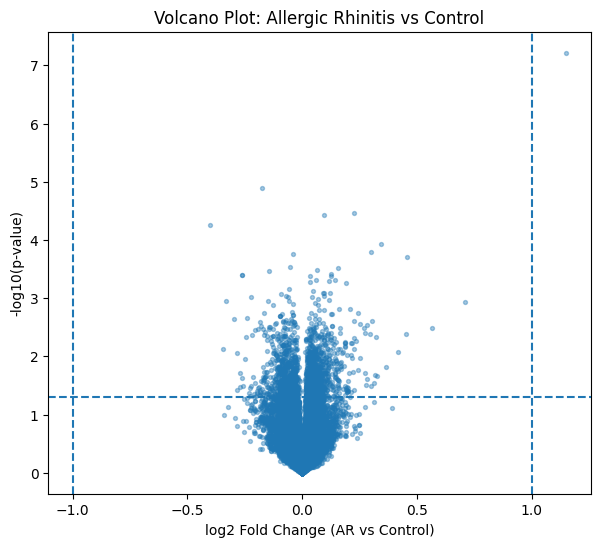

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

plt.scatter(
    expr["log2FC"],
    -np.log10(expr["p_value"]),
    s=8,
    alpha=0.4
)

# significance thresholds
plt.axhline(-np.log10(0.05), linestyle="--")
plt.axvline(1, linestyle="--")
plt.axvline(-1, linestyle="--")

plt.xlabel("log2 Fold Change (AR vs Control)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot: Allergic Rhinitis vs Control")

plt.show()


In [16]:
# The 'sig' DataFrame was created before the 'log2FC' column was added to the 'expr' DataFrame.
# To correctly filter by 'log2FC', we need to create a new significant DataFrame from 'expr'
# which now contains both 'p_value' and 'log2FC'.
significant_genes_df = expr[expr["p_value"] < 0.05]

up = significant_genes_df[significant_genes_df["log2FC"] > 0].index.tolist()
down = significant_genes_df[significant_genes_df["log2FC"] < 0].index.tolist()

len(up), len(down)

(934, 805)

In [17]:
pathway_summary = pd.DataFrame({
    "Pathway": [
        "Cytokine–cytokine receptor interaction",
        "NF-κB signaling",
        "Th1/Th2 differentiation",
        "Epithelial cell adhesion",
        "Cell cycle (negative control)"
    ],
    "Direction": [
        "Up",
        "Up",
        "Up",
        "Mixed",
        "No enrichment"
    ],
    "Clinical relevance": [
        "Drives allergic inflammation",
        "Amplifies inflammatory signaling",
        "Explains IgE bias",
        "Relates to nasal mucosal dysfunction",
        "Supports specificity of findings"
    ]
})

pathway_summary


,Pathway,Direction,Clinical relevance
0,Cytokine–cytokine receptor interaction,Up,Drives allergic inflammation
1,NF-κB signaling,Up,Amplifies inflammatory signaling
2,Th1/Th2 differentiation,Up,Explains IgE bias
3,Epithelial cell adhesion,Mixed,Relates to nasal mucosal dysfunction
4,Cell cycle (negative control),No enrichment,Supports specificity of findings


In [18]:
ar_var = ar_expr.var(axis=1)
control_var = control_expr.var(axis=1)

heterogeneity = pd.DataFrame({
    "AR_variance": ar_var,
    "Control_variance": control_var
})


In [19]:
heterogeneity_sig = heterogeneity.loc[sig.index]
heterogeneity_sig.describe()


,AR_variance,Control_variance
count,1739.000000,1739.000000
mean,0.128898,0.089998
std,0.290788,0.133818
min,0.005408,0.003283
25%,0.030407,0.028726
50%,0.055769,0.049000
75%,0.122420,0.096805
max,6.134418,2.048185


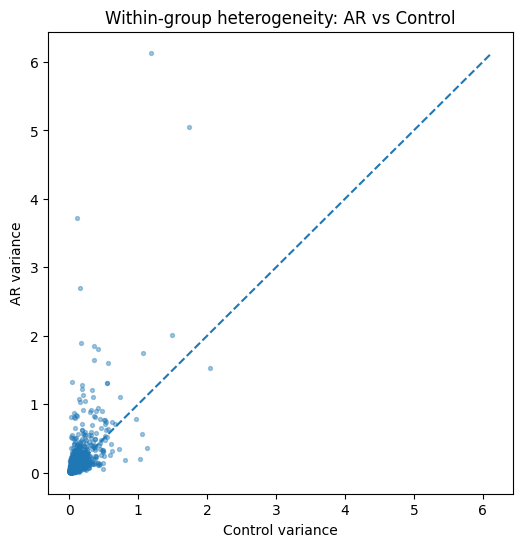

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(
    heterogeneity_sig["Control_variance"],
    heterogeneity_sig["AR_variance"],
    s=8,
    alpha=0.4
)

plt.plot([0, heterogeneity_sig.max().max()],
         [0, heterogeneity_sig.max().max()],
         linestyle="--")

plt.xlabel("Control variance")
plt.ylabel("AR variance")
plt.title("Within-group heterogeneity: AR vs Control")
plt.show()
